In [49]:
import pandas as pd
from collections import Counter
from time import time

In [19]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [8]:
huizhou_stop_words = [u'的', u'了', u'在', u'是', u'安徽', u'和', u'有', u'我', u'年', u'上', u'他', u'我们', u'及',
                      u'为', u'与', u'人', u'也', u'于', u'中', u'就', u'都', u'在线', u'等', u'不', u'网站', u'你', 
                      u'一个', u'到', u'之', u'对', u'说', u'进入', u'后', u'月', u'将', u'时', u'又', u'被', u'会员'
                     u'版权', u'论坛', u'以', u'而', u'着', u'下', u'这', u'但', u'要', u'或', u'首页', u'这', u'更',
                     u'地', u'从', u'卡', u'来', '多', u'日', u'她', u'还', u'联系', u'那', u'一处', u'一直', u'个', 
                     u'向', u'并', u'曾', u'这样', u'里', u'合肥', u'推荐', u'专栏', u'相关', u'当前', u'所有', u'中心'
                     u'频道', u'编辑', u'位置', u'第一', u'社区', u'看', '中安', u'安徽省', u'大', u'许可证', u'许可',
                     u'让', u'没有', u'什么', u'其', '请', '该', '用', '积分', u'凤阳', u'一篇', u'版权', u'县', u'这里',
                      u'就是', u'生于', u'他们', u'它', u'男', u'去', u'会', u'由', u'一', u'做', u'所', u'毕业', u'一种',
                     u'协会会员', u'把', u'能', u'至', u'这个', u'自己', u'黄山市', u'出', u'如', u'如',u'可以', u'很',
                     u'成为', u'好', u'先生', u'中国', u'集团', u'江淮', u'网', u'特色', u'全国', u'新', u'作为', u'师专',
                     u'则', u'重要', u'们', u'给', u'这些', u'过', u'安', u'最', u'现在', u'得', u'国家', u'使', u'这种',
                     u'主要', u'具有', u'人们', u'已', u'以及', u'有着', u'一定', u'一些', u'许多', u'进行', u'由于', u'却', 
                      u'其中', u'只是', u'当时', u'方面', u'即 ', u'徽', u'内容', u'还有', u'之一', u'者 ', u'不仅', u'者',
                      u'特别', u'名', u'提供', u'同时', u'大量', u'因此', u'即']

In [9]:
import unicodedata
def remove_non_chinese(s):
    r = [c for c in s if unicodedata.category(c).startswith('L')]
#print r
    return ''.join(r)

In [10]:
def ch_title_letters_removal(x):
    #print 'coming', x
    t = x.strip('  ')
    if(len(t)) == 0:
        return None
    
    if(len(x) > 0):
        #s = x.strip()
        s = remove_non_chinese(x)
        if len(s) > 0 and s not in huizhou_stop_words:
            return s.strip()
        else:
            return None
    return None

In [4]:
df = pd.read_csv('../data/clean/huizhou_full_v1_1.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169079 entries, 0 to 169078
Data columns (total 6 columns):
url            169079 non-null object
title          169079 non-null object
summary        169079 non-null object
s_vec_cnt      169079 non-null object
content        169079 non-null object
content_seg    169079 non-null object
dtypes: object(6)
memory usage: 7.7+ MB


In [67]:
from time import time
import numpy as np
import math

class Toolbox (object):
    def __init__(self):
        self.init = 1
        
    def sort_dict (self, d, max=68):
        t = sorted(d.items(), key=lambda x: (-x[1], x[0]))
        return t[:max]
    
    def add_dict (self, x, y):
        d = { k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y) }
        return d
    
    def create_dict(self, k1, v1, filters = True):
        if filters == True:
            k1_list0 = k1.strip('()').split(',')
            v1_list0 = v1.strip('()').split(',')
            #print v1_list0
            #print k1_list0
            k1_list1 = filter(None, k1_list0)        
            v1_list1 = filter(None, v1_list0)
        else:
            k1_list1 = k1
            v1_list1 = v1
        
        #print ' '.join(k1_list1)
        k2_list1 = [item.decode('utf-8') for item in k1_list1]
        v2_list1 = [float(item) for item in v1_list1]

    def create_vec(self, k1, v1):
        return (zip(k1, v1))
    
    def get_dict_top_n(self, d, max=68):
        ret = self.sort_dict(d, max)
        words, fq = zip(*ret)
        sum_up = sum(fq)
        fq_normalized = tuple(item/sum_up for item in fq)
        
        return dict(zip(words, fq_normalized))
    
    #calculate cosine between two dictionaries
    def get_sim(self, vec1, vec2):
        
        #get intersection
        intersection = set(vec1.keys()) & set(vec2.keys())
        
        #print intersection
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        #print 'num ---', numerator
        #print vec1.keys()
        #print vec1.values()
        #print vec2.keys()
        #print vec2.values()        
        
        if numerator > 0.0:
            sum1 = sum([vec1[x]**2 for x in vec1.keys()])
            sum2 = sum([vec2[x]**2 for x in vec2.keys()])
            denominator = math.sqrt(sum1) * math.sqrt(sum2)
        else:
            return 0.0

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator
        
    def sum_vects(self, vects):
        sum_vects = None
        for vec in vects:
            if sum_vects == None:
                sum_vects = vec
            else:
                sum_vects = self.add_dict(sum_vects, vec)
        #only return first 100 after additions
        #print type(sum_vecs)
        return self.get_dict_top_n(sum_vects)
    
    def unserialized(self, x, eval_val=True):
        #print '----- in'
        #print x
        d = dict()
        s = x.strip('{}')
        #s = s.strip('[]')
        ret = s.split(',')

        idx = 0
        #print ret
        for t in ret:
            r = t.split(':')
            #print r[0], r[1]
            key = eval(r[0].decode('utf-8'))
            if idx >= 100:
                if eval_val == True:
                    d[key] = int(r[1])
                else:
                    d[key] = r[1]
                idx += 1
        #print len(ret)
        #print 'split -----'
        #print ' '.join(ret)
        return d
        
    def get_centroid_df(self, check, num=2000):        
        if len(check) > num:
            #sampling     
            ratio = num*1.0/len(check)
            print 'ratio ---', ratio 
            msk = np.random.rand(len(check)) < ratio
            tmp = check[msk]
            check = tmp
    
        check.info()
        check_vecs = check['s_vec']
        return self.sum_vects(check_vecs) 

    def get_centroid_str(self, df, in_dict):        
        df['s_check'] = df.s_vec.map(lambda x: self.set_contained_flag(x, in_dict))
        check = df[df['s_check'] == True]

        return self.get_centroid_df(check)

    def set_contained_flag(self, x, y):
        x_keys = x.keys()
        y_keys = y.keys()
        for s in y_keys:
            if s in x_keys:
                return True
        return False
    
    def get_dict_from_input(self, txt):
        ret = txt.split()
        if len(ret) == 0:
            return None
        
        d = dict()
        for t in ret:
            d[t] = 1.0/len(ret)
        
        return d

In [68]:
aT = Toolbox()

In [51]:
global idx
idx = 0
def map_s_vec(x):
    global idx
    
    print idx
    s = x.decode('utf-8')
    words = s.split()
    #print words
    flatten = [ch_title_letters_removal(item) for item in words if ch_title_letters_removal(item) != None ]
    count = Counter(flatten)
    top_68 = count.most_common(68)
    idx += 1
    return dict(top_68)

In [56]:
vec = map_s_vec(df.iloc[1]['content_seg'])

In [57]:
print ' '.join(vec.keys())

In [22]:
print df.iloc[1]['content_seg']

In [58]:
t0 = time()
df['s_vec'] = df.content_seg.map(lambda x: map_s_vec(x)) #946s
print time() - t0

In [55]:
df.head()

,url,title,summary,s_vec_cnt,content,content_seg,s_vec
0,http://cul.anhuinews.com/system/2016/11/28/007...,洪建华夫妇的竹刻人生,。不久前，我们几名政协委员应邀到正在建设中的黄山市徽派雕刻博物馆参观考察时，洪建华一边介绍新...,"{u'融入': 1, u'国内外': 1, u'夫妻俩': 1, u'艺术馆': 2, u'...",谁能想到，洪建华夫妇这对一无学历、二无家传、三无师承的“三无大师”成了省级非物质文化遗产·徽...,谁 能 想到 ， 洪 建华 夫妇 这 对 一 无 学历 、 二 无 家传 、 三无 师承 的...,{u'地处国道边的这座新馆独特的景观设计加上徽式的建设风格确实让人眼睛一亮洪建华介绍说新馆占...
1,http://cul.anhuinews.com/system/2016/11/21/007...,徽州民歌传人操明花校园授艺,。“磨米磨麦，磨米磨麦……”随着教室里传来一阵阵悦耳动听的方言民歌声，操明花正兴致勃勃地教同...,"{u'传来': 1, u'小学': 1, u'原汁原味': 1, u'明花': 1, u'磨...",近日，省非物质文化遗产徽州民歌传承人操明花前往休宁县海阳二小、歙县城关小学和徽州区岩寺镇中心...,近日 ， 省非 物质 文化遗产 徽州 民歌 传承 人操 明花 前往 休宁县 海阳 二小 、 ...,{u'磨米磨麦磨米磨麦随着教室里传来一阵阵悦耳动听的方言民歌声操明花正兴致勃勃地教同学们学唱...
2,http://cul.anhuinews.com/system/2016/11/03/007...,黄山楹联漫谈,。黄山雄伟奇丽、气势非凡，原省文联主席赖少其说，非有大手笔，不能画黄山。有“二联”站得高，看...,"{u'气派': 1, u'名句': 1, u'唱道': 1, u'千丈': 1, u'凿刻'...",黄山楹联第一人当推明朝诗人余绍祉。他遍历祖国名山大川，见到无数奇峰怪石，却感到抵不上黄山峰林...,黄山 楹联 第一 人当 推 明朝 诗人 余绍祉 。 他 遍历 祖国 名山大川 ， 见到 无数...,{u'黄山旅游楹联资源丰富亟待有识见同爱好的人来开发笔者试从黄山的奇峰怪石和名松中加以杜撰用...
3,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州木雕艺术,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,"{u'吉祥图案': 1, u'少数': 1, u'显示': 1, u'内': 1, u'木板...",徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州 民居 、 家具 木板 和 圆木 雕刻 艺术 的 简称 。 木雕 在 旧属 徽州 各县 ...,{u'徽州民居家具木板和圆木雕刻艺术的简称木雕在旧属徽州各县分布之广在全国屈指可数宅院内的屏...
4,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州砖雕艺术,。从早期的简单粗犷、朴素的纹样，逐步演变到后期的繁腹、细致华丽的结构，形成了自己独特的艺术风...,"{u'嵌窃时': 1, u'要求': 1, u'厅': 1, u'严谨': 1, u'颇':...",徽州砖雕徽州砖雕的造型，来源于汉画象砖。汉画象砖大都是模印砖坯刻画后入密烧制，嵌窃时再进行修...,徽州 砖雕 徽州 砖雕 的 造型 ， 来源于 汉 画象 砖 。 汉 画象 砖 大都 是 模印...,{u'徽州砖雕徽州砖雕的造型来源于汉画象砖汉画象砖大都是模印砖坯刻画后入密烧制嵌窃时再进行修...


In [54]:
import json
with open('../data/centroids/hz_centroid_68_v1.json', 'r') as fp:
    hz_centroid = json.load(fp)

In [61]:
global aT
global k
k = 0

In [64]:
def map_s_sig(x, y):
    global aT, k
    print k
    k += 1
    return aT.get_sim(x, y)

In [69]:
t0 = time()
df['s_sig'] = df.s_vec.map(lambda x: map_s_sig(x, hz_centroid)) #150s
print time() - t0

In [70]:
df.head()

,url,title,summary,s_vec_cnt,content,content_seg,s_vec,s_sig
0,http://cul.anhuinews.com/system/2016/11/28/007...,洪建华夫妇的竹刻人生,。不久前，我们几名政协委员应邀到正在建设中的黄山市徽派雕刻博物馆参观考察时，洪建华一边介绍新...,"{u'融入': 1, u'国内外': 1, u'夫妻俩': 1, u'艺术馆': 2, u'...",谁能想到，洪建华夫妇这对一无学历、二无家传、三无师承的“三无大师”成了省级非物质文化遗产·徽...,谁 能 想到 ， 洪 建华 夫妇 这 对 一 无 学历 、 二 无 家传 、 三无 师承 的...,"{u'很多': 3, u'竹木': 4, u'洪': 20, u'雕刻': 21, u'展示...",0.148665
1,http://cul.anhuinews.com/system/2016/11/21/007...,徽州民歌传人操明花校园授艺,。“磨米磨麦，磨米磨麦……”随着教室里传来一阵阵悦耳动听的方言民歌声，操明花正兴致勃勃地教同...,"{u'传来': 1, u'小学': 1, u'原汁原味': 1, u'明花': 1, u'磨...",近日，省非物质文化遗产徽州民歌传承人操明花前往休宁县海阳二小、歙县城关小学和徽州区岩寺镇中心...,近日 ， 省非 物质 文化遗产 徽州 民歌 传承 人操 明花 前往 休宁县 海阳 二小 、 ...,"{u'声乐': 1, u'原生态': 1, u'原汁原味': 1, u'传来': 1, u'...",0.276219
2,http://cul.anhuinews.com/system/2016/11/03/007...,黄山楹联漫谈,。黄山雄伟奇丽、气势非凡，原省文联主席赖少其说，非有大手笔，不能画黄山。有“二联”站得高，看...,"{u'气派': 1, u'名句': 1, u'唱道': 1, u'千丈': 1, u'凿刻'...",黄山楹联第一人当推明朝诗人余绍祉。他遍历祖国名山大川，见到无数奇峰怪石，却感到抵不上黄山峰林...,黄山 楹联 第一 人当 推 明朝 诗人 余绍祉 。 他 遍历 祖国 名山大川 ， 见到 无数...,"{u'气派': 1, u'名句': 1, u'唱道': 1, u'文联': 3, u'凿刻'...",0.047619
3,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州木雕艺术,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,"{u'吉祥图案': 1, u'少数': 1, u'显示': 1, u'内': 1, u'木板...",徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州 民居 、 家具 木板 和 圆木 雕刻 艺术 的 简称 。 木雕 在 旧属 徽州 各县 ...,"{u'吉祥图案': 1, u'少数': 1, u'显示': 1, u'内': 1, u'木板...",0.221148
4,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州砖雕艺术,。从早期的简单粗犷、朴素的纹样，逐步演变到后期的繁腹、细致华丽的结构，形成了自己独特的艺术风...,"{u'嵌窃时': 1, u'要求': 1, u'厅': 1, u'严谨': 1, u'颇':...",徽州砖雕徽州砖雕的造型，来源于汉画象砖。汉画象砖大都是模印砖坯刻画后入密烧制，嵌窃时再进行修...,徽州 砖雕 徽州 砖雕 的 造型 ， 来源于 汉 画象 砖 。 汉 画象 砖 大都 是 模印...,"{u'前后': 1, u'厅': 1, u'严谨': 1, u'颇': 1, u'根据': ...",0.111781


In [87]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline 

In [76]:
df_short = df[df['s_sig'] > 0.0]

In [93]:
df_short['s_dist'] = 1 - df_short['s_sig']

In [97]:
df_short.info()

In [83]:
df_short['s_sig'].min(), df_short['s_sig'].max() 

(0.00010166595950395828, 0.93458093757435134)

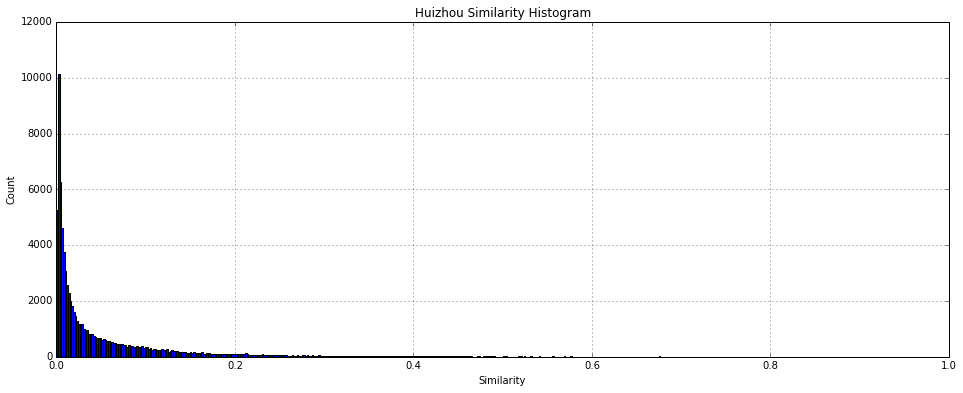

In [95]:
df_short['s_sig'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou Similarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

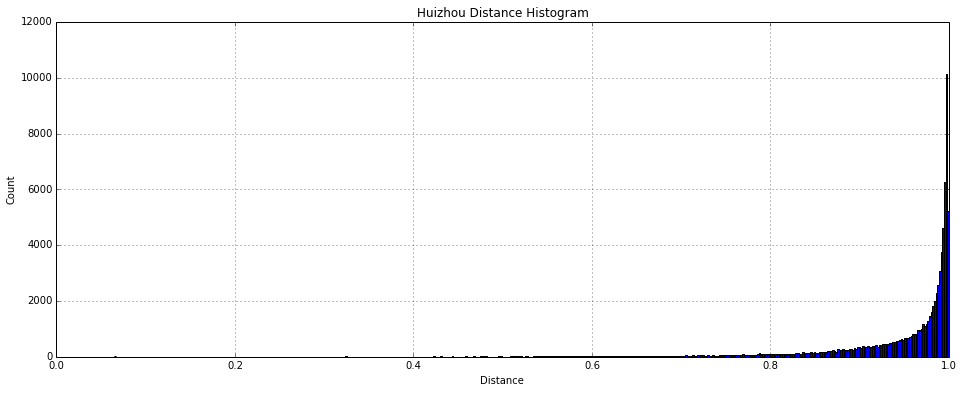

In [96]:
df_short['s_dist'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou Distance Histogram')
plt.xlabel('Distance')
plt.ylabel('Count')

In [86]:
for k in range (0, 10):
    mask = (df['s_sig'] > k/10.0) & (df['s_sig'] < (k+1)/10.0)
    df_0 = df[mask]
    print len(df_0)

In [98]:
df.to_csv('../data/sim/hz_sim_v1.csv', encoding='utf-8', index=False)